## AGN Structure Function Error ##

This metric, contributed by Weixiang Yu, estimates the error in the structure function of an AGN, based on the timing and depth of a series of observations. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [3]:
opsim_file = get_baseline()
runName = os.path.split(opsim_file)[-1].replace('.db', '')
print(f'{runName} : {opsim_file}')

baseline_nexp2_v1.7_10yrs : /Users/lynnej/rubin_sim_data/sim_baseline/baseline_nexp2_v1.7_10yrs.db


In [4]:
# Set up output directories
outDir = 'test_agn'
resultsDb = maf.ResultsDb(outDir)

In [5]:
# Connect to database
opsdb = maf.OpsimDatabase(opsim_file)

In [6]:
# The metric is intended to run per filter
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')

# And in each filter, the 'test' magnitude for the AGN is intended to be about 0.5 mags above the 
# median single-visit limiting magnitudes of all visits in the current baseline

# We could look those up, or calculate them here ..

visit_depth = {}
for f in filterlist:
    m = maf.MedianMetric(col='fiveSigmaDepth')
    sql = f'filter == "{f}"'
    allvisits_slicer = maf.UniSlicer()
    visit_depth[f] = maf.MetricBundle(m, allvisits_slicer, sql, runName=runName)

g = maf.MetricBundleGroup(visit_depth, opsdb, outDir=outDir, resultsDb=resultsDb)
g.runAll()

Querying database SummaryAllProps with constraint filter == "u" for columns ['fiveSigmaDepth']
Found 130925 visits
Running:  ['u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "y" for columns ['fiveSigmaDepth']
Found 404071 visits
Running:  ['y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "z" for columns ['fiveSigmaDepth']
Found 397742 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "i" for columns ['fiveSigmaDepth']
Found 455743 visits
Running:  ['i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "r" for columns ['fiveSigmaDepth']
Found 452001 

In [7]:
# Put the results into a nicer to read dictionary
median_m5 = {}
for f in filterlist:
    median_m5[f] = round(visit_depth[f].metricValues[0], 2)
    
pd.DataFrame(median_m5, index=['Median Visit 5-sigma Depth']).T

,Median Visit 5-sigma Depth
u,23.39
g,24.44
r,24.00
i,23.43
z,22.78
y,22.00


In [8]:
# Set up AGN SFError test magnitudes
agn_m5 = {}
for f in filterlist:
    agn_m5[f] = median_m5[f] - 0.5
print(agn_m5)
    
pd.DataFrame(agn_m5, index=['AGN SFError magnitude']).T

{'u': 22.89, 'g': 23.94, 'r': 23.5, 'i': 22.93, 'z': 22.28, 'y': 21.5}


,AGN SFError magnitude
u,22.89
g,23.94
r,23.50
i,22.93
z,22.28
y,21.50


In [9]:
# Check out the AGN SFErrorMetric 
maf.SFErrorMetric??

In [10]:
sf_error = {}
nside = 64
s = maf.HealpixSlicer(nside=nside, useCache=False)
for f in filterlist:
    m = maf.SFErrorMetric(mag=agn_m5[f], snr_cut=5)
    # This uses a dust map, which raises a warning (not serious) if nside not matched
    # Note that one dust map is translated to different extinctions values for different filters - 
    # automatically with rubin_sim.utils.Dust_values (used in the SFErrorMetric)
    dust_map = maf.DustMap(nside=nside)
    sql = f'filter == "{f}"'
    sf_error[f] = maf.MetricBundle(m, s, sql, runName=runName,
                                   mapsList=[dust_map],
                                   summaryMetrics=maf.extendedSummary())

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [11]:
g = maf.MetricBundleGroup(sf_error, opsdb, outDir=outDir, resultsDb=resultsDb)
g.runAll()

Querying database SummaryAllProps with constraint filter == "u" for columns ['fieldRA', 'fiveSigmaDepth', 'rotSkyPos', 'fieldDec', 'filter', 'observationStartMJD']
Found 130925 visits
Running:  ['u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "y" for columns ['fieldRA', 'fiveSigmaDepth', 'rotSkyPos', 'fieldDec', 'filter', 'observationStartMJD']
Found 404071 visits
Running:  ['y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "z" for columns ['fieldRA', 'fiveSigmaDepth', 'rotSkyPos', 'fieldDec', 'filter', 'observationStartMJD']
Found 397742 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "i" for columns ['fieldRA', 'fiveSigmaDepth', 'rotSkyPos', 'fiel

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


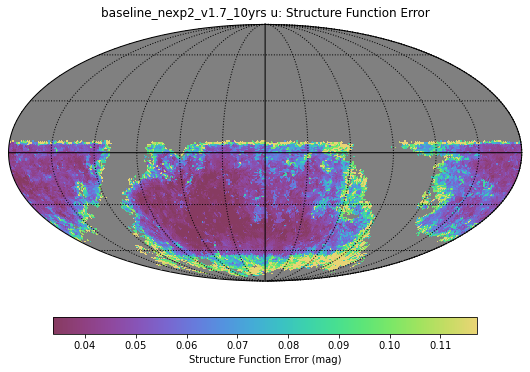

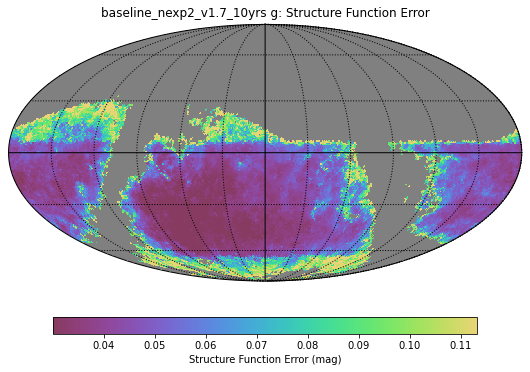

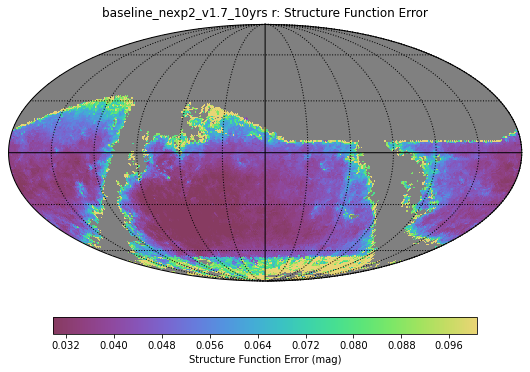

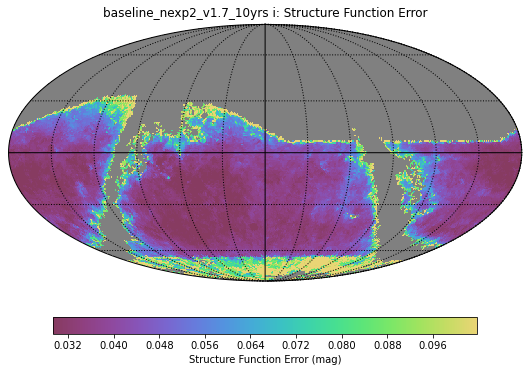

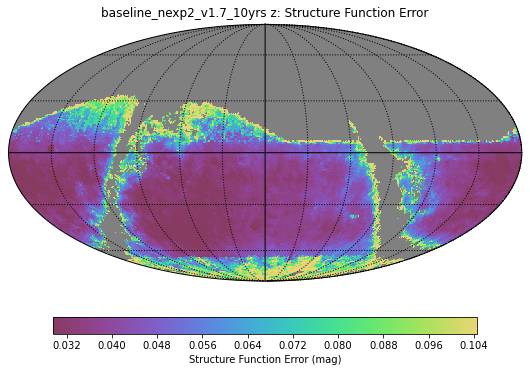

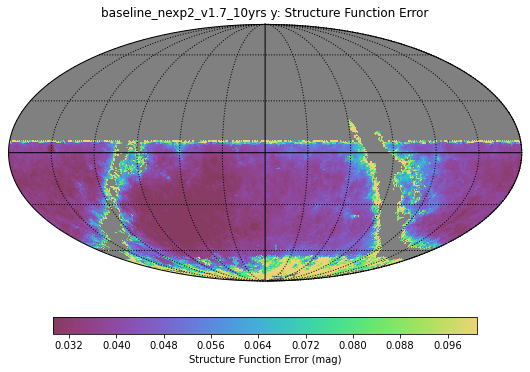

In [12]:
ph = maf.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for f in sf_error:
    ph.setMetricBundles([sf_error[f]])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,5), 'percentileClip': 90})

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 224 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 281 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 239 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 353 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


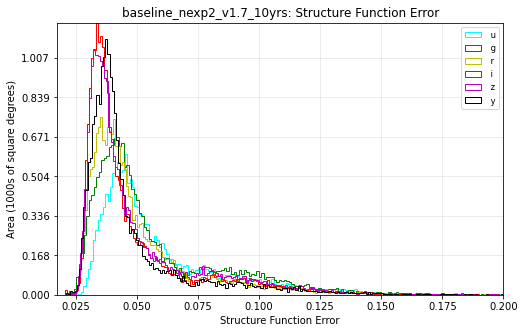

In [13]:
ph.setMetricBundles(sf_error)
ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,5), 'xMax': 0.2,})
plt.grid(True, alpha=0.3)

In [14]:
# SF Error summary values per band
pd.DataFrame([sf_error[f].summaryValues for f in filterlist], index=filterlist)

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
u,0.060428,0.028661,0.050299,0.390917,0.025927,333,0,20097,0.041832,0.070260
g,0.056985,0.027972,0.046708,0.373226,0.021009,347,0,24084,0.038380,0.067303
r,0.050880,0.023875,0.043078,0.335284,0.024435,524,0,25857,0.035983,0.056531
i,0.049034,0.025576,0.038987,0.381596,0.020514,517,0,27296,0.033735,0.053061
z,0.050452,0.025621,0.040264,0.372509,0.021343,492,0,28306,0.034146,0.056571
y,0.047980,0.023893,0.039682,0.379712,0.020829,575,0,25303,0.034892,0.049821


Given that we do also care about how much of the sky the AGN structure function error is below a given threshhold,  we can add another summary statistic, now we know a reasonable value to set as the threshold.

In [17]:
threshold = 0.04
metric = maf.AreaThresholdMetric(upper_threshold=threshold)

for f in sf_error:
    sf_error[f].setSummaryMetrics([metric])
    sf_error[f].computeSummaryStats()

In [18]:
pd.DataFrame([sf_error[f].summaryValues for f in filterlist], index=filterlist)

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile,AreaThreshold
u,0.060428,0.028661,0.050299,0.390917,0.025927,333,0,20097,0.041832,0.070260,3239.673471
g,0.056985,0.027972,0.046708,0.373226,0.021009,347,0,24084,0.038380,0.067303,6062.217999
r,0.050880,0.023875,0.043078,0.335284,0.024435,524,0,25857,0.035983,0.056531,8513.794737
i,0.049034,0.025576,0.038987,0.381596,0.020514,517,0,27296,0.033735,0.053061,12210.883244
z,0.050452,0.025621,0.040264,0.372509,0.021343,492,0,28306,0.034146,0.056571,11706.467763
y,0.047980,0.023893,0.039682,0.379712,0.020829,575,0,25303,0.034892,0.049821,10946.907014
